In [1]:
%load_ext autoreload
%autoreload 2
import mkl
mkl.set_num_threads(1)

48

In [2]:
# compare raw and smoothed aeff

In [3]:
import pickle
from collections import namedtuple

import numpy as np
from copy import copy
import pandas as pd
import seaborn as sns

from scipy.optimize import fmin_l_bfgs_b
from scipy.stats import chi2, norm
from scipy.interpolate import RegularGridInterpolator

from astropy.coordinates import SkyCoord

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import settings as st

Could not import healpy.
functions plot_area, add_catalog, and add_extended_plane will not work.


# raw effective area

In [4]:
from aeff_calculations import read_effective_area

In [20]:
public_data_aeff = read_effective_area()
# log10(E_nu/GeV)_min log10(E_nu/GeV)_max
# Dec_nu_min[deg] Dec_nu_max[deg]
# A_Eff[cm^2]

# the file contains all bin edges

sindec_bins = np.unique(
    np.sin(np.deg2rad([public_data_aeff.Dec_nu_min, public_data_aeff.Dec_nu_max]))
)
sindec_bins = np.round(sindec_bins, 2)
sindec_mids = st.get_mids(sindec_bins)
sindec_width = np.diff(sindec_bins)

log_ebins = np.unique([public_data_aeff.logE_nu_min, public_data_aeff.logE_nu_max])
log_emids = st.get_mids(log_ebins)
ebins = np.power(10, log_ebins)
emids = np.power(10, log_emids)
ewidth = np.diff(ebins)

aeff_icecube_full = (
    public_data_aeff["A_eff"].values.reshape(len(sindec_mids), len(emids)).T
)


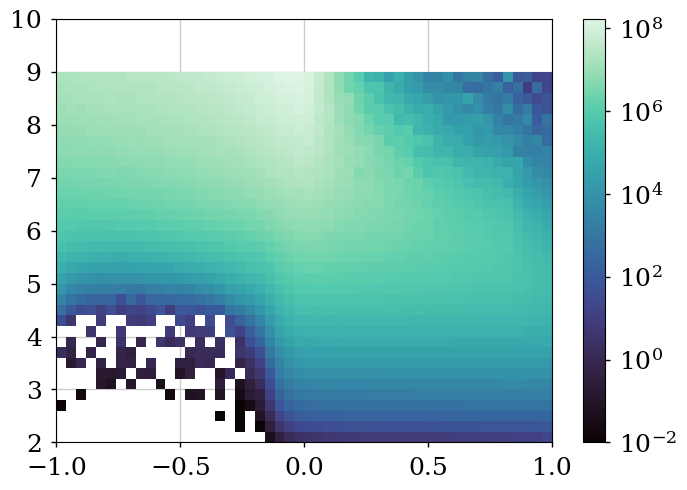

In [14]:

plt.pcolormesh(sindec_bins, log_ebins, aeff_icecube_full, norm=LogNorm())
plt.colorbar()

# smoothing

In [15]:
from scipy.interpolate import griddata, RectBivariateSpline

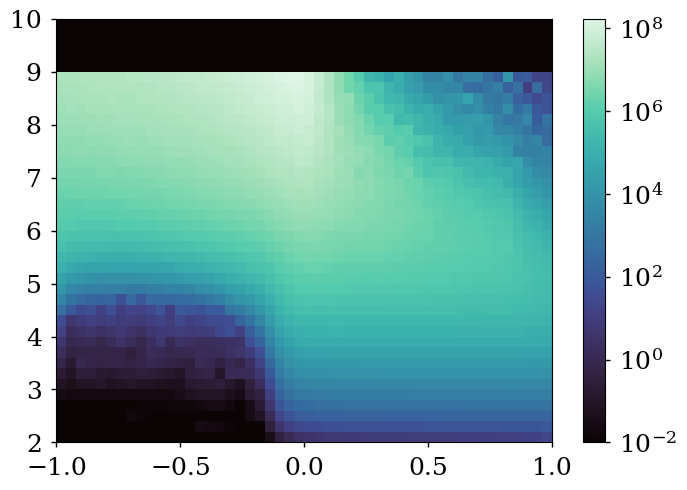

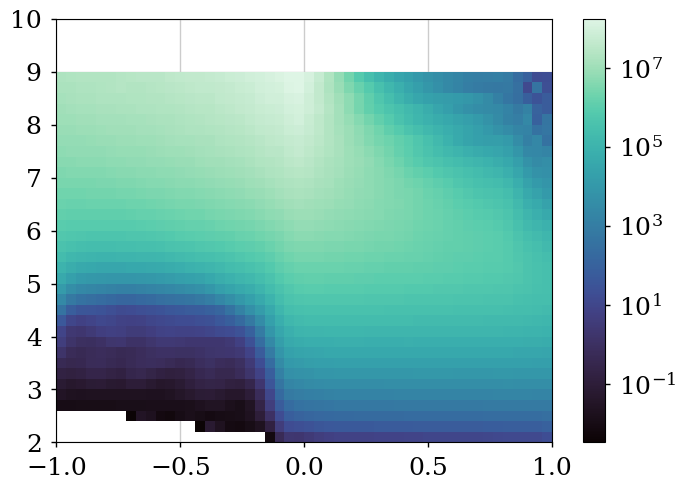

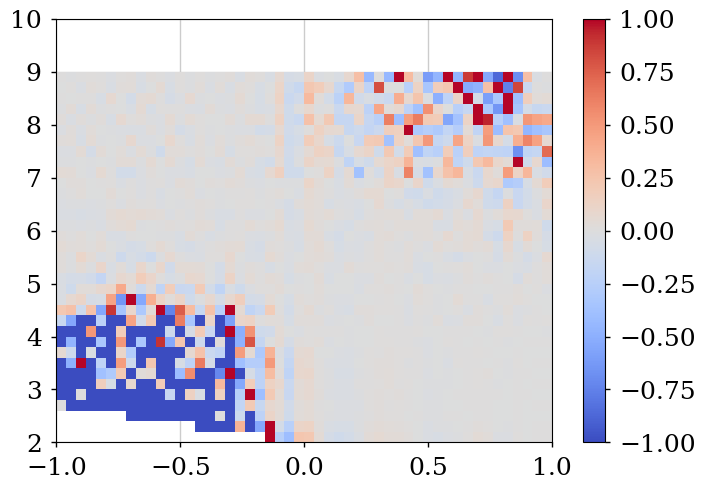

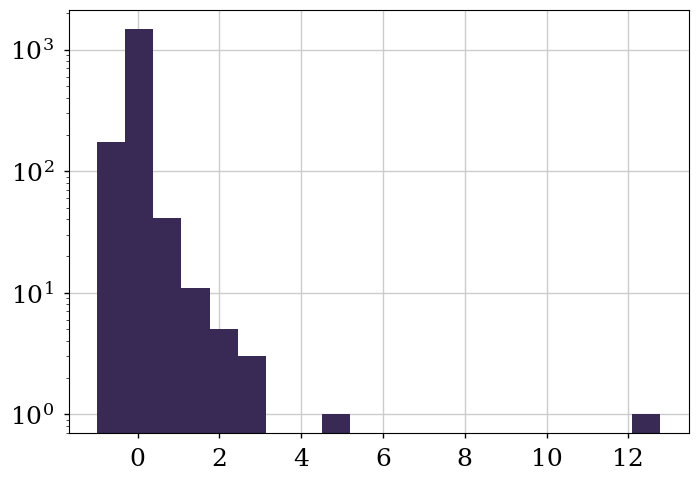

In [21]:
x = np.arange(0, aeff_icecube_full.shape[1])
y = np.arange(0, aeff_icecube_full.shape[0])
# mask invalid values
array = np.ma.masked_invalid(np.log10(aeff_icecube_full))
xx, yy = np.meshgrid(x, y)
# get only the valid values
x1 = xx[~array.mask]
y1 = yy[~array.mask]
newarr = array[~array.mask]

GD1 = griddata((x1, y1), newarr.ravel(), (xx, yy), method="linear")
GD1[np.isnan(GD1)] = -5

interp_aeff = 10**GD1
interp_aeff[np.isnan(interp_aeff)] = 0
smth_aeff_spl = RectBivariateSpline(sindec_mids, log_emids, GD1.T, s=20)

smooth_aeff_icecube_full = 10 ** smth_aeff_spl(sindec_mids, log_emids).T
smooth_aeff_icecube_full[smooth_aeff_icecube_full < 1e-4] = 0
plt.figure()
plt.pcolormesh(sindec_bins, log_ebins, 10**GD1, norm=LogNorm(vmin=1e-2))
plt.colorbar()
plt.figure()
plt.pcolormesh(sindec_bins, log_ebins, smooth_aeff_icecube_full, norm=LogNorm())
plt.colorbar()
plt.figure()
plt.pcolormesh(
    sindec_bins,
    log_ebins,
    aeff_icecube_full / smooth_aeff_icecube_full - 1,
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
)
plt.colorbar()

plt.figure()
_ = plt.hist(
    (aeff_icecube_full / smooth_aeff_icecube_full - 1).flatten(),
    bins=20,
    label="linear"
)
plt.yscale("log")



# prepared effective area

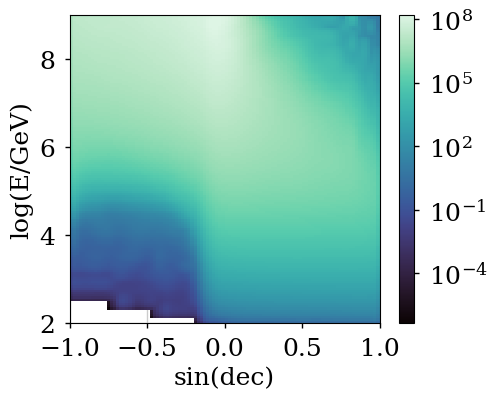

In [9]:
with open(st.join(st.LOCALPATH, "effective_area_MH_full.pckl"), "rb") as f:
    aeff_2d = pickle.load(f)

# plot the effective area (only up-going events)
aeff_2d["IceCube"].plot(norm=LogNorm())



# comparison

In [34]:
raw_aeff_spl = RectBivariateSpline(sindec_mids, log_emids, GD1.T, s=0, kx=1, ky=1)

In [39]:
aeff_2d["IceCube"].bin_mids[0]

array([-0.99, -0.97, -0.95, -0.93, -0.91, -0.89, -0.87, -0.85, -0.83,
       -0.81, -0.79, -0.77, -0.75, -0.73, -0.71, -0.69, -0.67, -0.65,
       -0.63, -0.61, -0.59, -0.57, -0.55, -0.53, -0.51, -0.49, -0.47,
       -0.45, -0.43, -0.41, -0.39, -0.37, -0.35, -0.33, -0.31, -0.29,
       -0.27, -0.25, -0.23, -0.21, -0.19, -0.17, -0.15, -0.13, -0.11,
       -0.09, -0.07, -0.05, -0.03, -0.01,  0.01,  0.03,  0.05,  0.07,
        0.09,  0.11,  0.13,  0.15,  0.17,  0.19,  0.21,  0.23,  0.25,
        0.27,  0.29,  0.31,  0.33,  0.35,  0.37,  0.39,  0.41,  0.43,
        0.45,  0.47,  0.49,  0.51,  0.53,  0.55,  0.57,  0.59,  0.61,
        0.63,  0.65,  0.67,  0.69,  0.71,  0.73,  0.75,  0.77,  0.79,
        0.81,  0.83,  0.85,  0.87,  0.89,  0.91,  0.93,  0.95,  0.97,
        0.99])

In [35]:
raw_interp = (
    10 ** raw_aeff_spl(aeff_2d["IceCube"].bin_mids[0], aeff_2d["IceCube"].bin_mids[1])
)

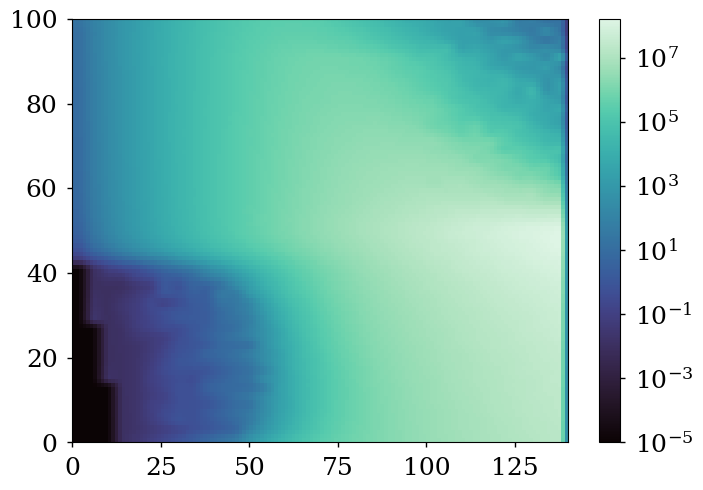

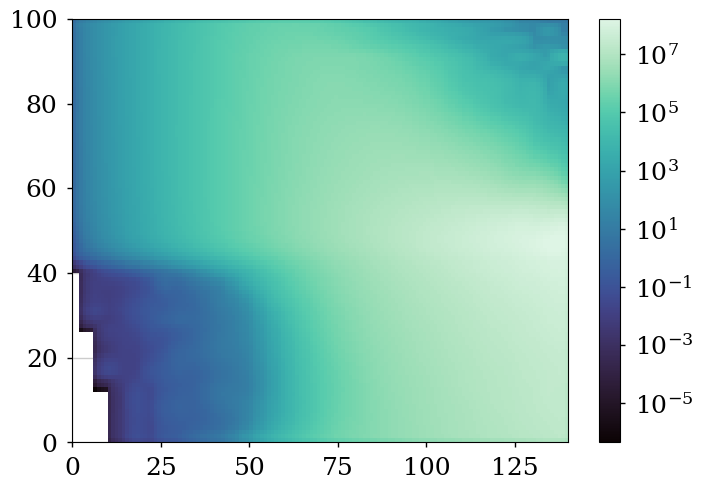

In [41]:
plt.figure()
plt.pcolormesh(raw_interp, norm=LogNorm())
plt.colorbar()

plt.figure()
plt.pcolormesh(aeff_2d["IceCube"].histo, norm=LogNorm())
plt.colorbar()

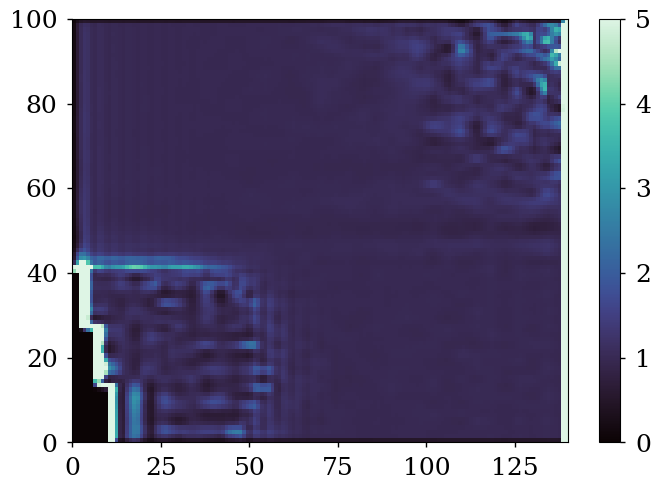

In [45]:
plt.pcolormesh(aeff_2d["IceCube"].histo / raw_interp, vmax=5)#, norm=LogNorm())
plt.colorbar()

[]

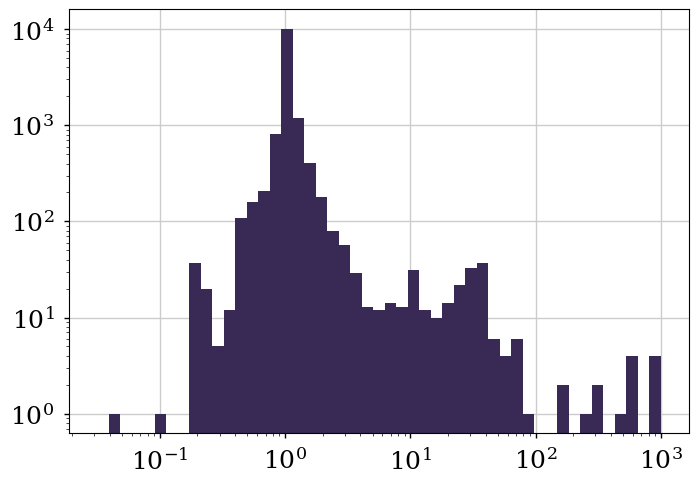

In [54]:
bins = np.logspace(-1.5, 3)
_ = plt.hist((aeff_2d["IceCube"].histo / raw_interp).flatten(), bins=bins)
plt.loglog()